# covid-nsw
Driven by SQL, I explore [NSW COVID-19 cases by location](https://data.nsw.gov.au/search/dataset/ds-nsw-ckan-aefcde60-3b0c-4bc0-9af1-6fe652944ec2/details?q=).

## Setup

Create SQL engine and load input CSV into a SQLite table:

In [1]:
from glob import glob
import pandas as pd
from sqlalchemy import create_engine

engine = create_engine('sqlite://', echo=False)

covid_df = pd.read_csv(glob('./input/confirmed_cases*.csv')[0])
covid_df.to_sql('covid', 
                engine, 
                if_exists='replace', 
                index=False)
covid_df.head(3)

,notification_date,postcode,lhd_2010_code,lhd_2010_name,lga_code19,lga_name19,confirmed_by_pcr,confirmed_cases_count
0,2020-01-25,2071,X760,Northern Sydney,14500,Ku-ring-gai (A),NaN,1
1,2020-01-25,2121,X760,Northern Sydney,16260,Parramatta (C),NaN,1
2,2020-01-25,2134,X700,Sydney,11300,Burwood (A),NaN,1


## Cleaning

### Missing
There are missing values in both `postcode` and `confirmed_by_pcr` columns:

In [2]:
pd.read_sql_query("""
    SELECT SUM(CASE WHEN notification_date IS NULL THEN 1 ELSE 0 END) AS 'nd_miss',
        SUM(CASE WHEN postcode IS 'None' THEN 1 ELSE 0 END) AS 'pc_miss',
        SUM(CASE WHEN lhd_2010_code IS  NULL THEN 1 ELSE 0 END) AS 'lhdc_miss',
        SUM(CASE WHEN lhd_2010_name IS NULL THEN 1 ELSE 0 END) AS 'lhdn_miss',
        SUM(CASE WHEN lga_code19 IS NULL THEN 1 ELSE 0 END) AS 'lgac_miss',
        SUM(CASE WHEN lga_name19 IS NULL THEN 1 ELSE 0 END) AS 'lgan_miss',
        SUM(CASE WHEN confirmed_by_pcr IS NULL THEN 1 ELSE 0 END) AS 'pcr_miss',
        SUM(CASE WHEN confirmed_cases_count IS NULL THEN 1 ELSE 0 END) AS 'confirmed_cases_miss'
    FROM covid
    """, engine)

,nd_miss,pc_miss,lhdc_miss,lhdn_miss,lgac_miss,lgan_miss,pcr_miss,confirmed_cases_miss
0,0,530,0,0,0,0,41075,0


Although Local Government Area (LGA) information is not missing for rows with missing `postcode`, `postcode` is nevertheless difficult to impute as there can be multiple postcodes in an LGA (1:M).

Similarly, `confirmed_by_pcr` is difficult to impute. It records whether a case detected by Rapid Antigen Tests (RAT), reported to NSW Health, was also confirmed by PCR. All missing values were prior to 19 Jan 2022 and would be difficult to impute.

In [3]:
pd.read_sql_query("""
    SELECT MAX(notification_date) AS 'latest_pcr_miss_date'
    FROM covid
    WHERE confirmed_by_pcr IS NULL
    """, engine)

,latest_pcr_miss_date
0,2022-01-19


## Analysis
In this section, I use SQL queries and Python visualisations to highlight insights in the data.

### Daily Cases
Daily reported cases have overall trended upwards since reporting started on 25 Jan 2020. Daily cases peaked in Jan 2022, and then, less so, in Mar 2022. 

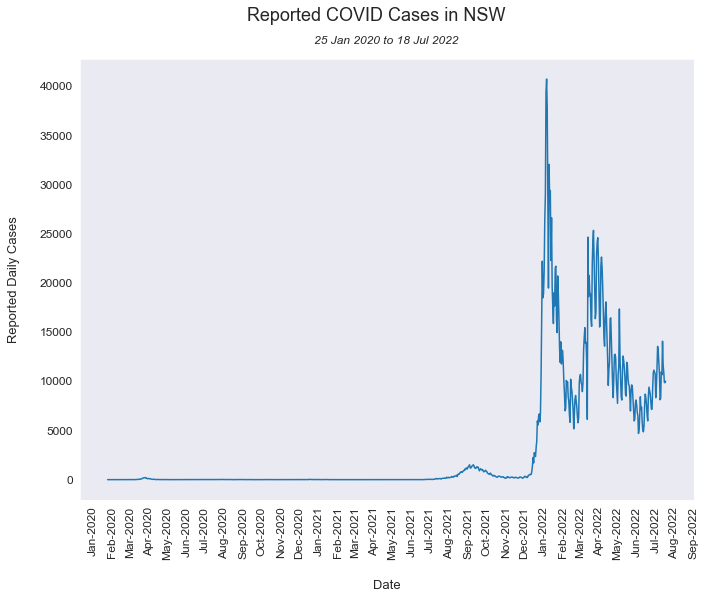

<Figure size 432x288 with 0 Axes>

In [72]:
import matplotlib.pyplot as plt
import matplotlib.dates as md
import seaborn as sns

# querying
daily_cases =\
    pd.read_sql_query("""
        SELECT DATE(notification_date) AS 'date',
            SUM(confirmed_cases_count) AS 'reported_cases'
        FROM covid
        GROUP BY 1
        """, engine)

# transforming and extracting from DataFrame for visualisation
daily_cases['date'] = pd.to_datetime(daily_cases['date'], 
                                     format='%Y-%m-%d')
start_date = daily_cases.date.min().strftime('%d %b %Y')
end_date = daily_cases.date.max().strftime('%d %b %Y')

# plotting visualisation
sns.set_style('dark')

fig, ax = plt.subplots(figsize=(11,8))
sns.lineplot(x='date', 
             y='reported_cases', 
             data=daily_cases, 
             ax=ax)

# setting x-axis ticks
ax.xaxis.set_major_locator(md.MonthLocator(bymonthday=1))
ax.xaxis.set_major_formatter(md.DateFormatter('%b-%Y'))
plt.setp(ax.xaxis.get_majorticklabels(), rotation=90)
ax.tick_params(axis='both', labelsize=12)

# modifying line-chart parameters
ax.figure.suptitle('Reported COVID Cases in NSW', fontsize=18)
ax.set_title(f'{start_date} to {end_date}', y=1.02, style='italic')
ax.set_xlabel('Date', fontsize=13, labelpad=20)
ax.set_ylabel('Reported Daily Cases', fontsize=13, labelpad=20)

fig.subplots_adjust(top=0.89)

plt.show()
plt.clf()

Drilling down, we see that the **10 highest daily reported cases occurred in January 2022.** 11th to 16th highest are in the smaller, March 2022 spike in the line chart above.

In [5]:
pd.read_sql_query("""
    SELECT
        RANK() OVER (
            ORDER BY SUM(confirmed_cases_count) DESC
        ) AS 'rank',
        DATE(notification_date) AS 'date',
        STRFTIME('%m-%Y', notification_date) AS 'month-year',
        SUM(confirmed_cases_count) AS 'reported_cases'
    FROM covid
    GROUP BY 2
    ORDER BY 4 DESC
    LIMIT 20
    """, engine)

,rank,date,month-year,reported_cases
0,1,2022-01-06,01-2022,40752
1,2,2022-01-05,01-2022,39431
2,3,2022-01-07,01-2022,37676
3,4,2022-01-10,01-2022,32070
4,5,2022-01-12,01-2022,29411
5,6,2022-01-04,01-2022,29031
6,7,2022-01-08,01-2022,28174
7,8,2022-01-11,01-2022,28137
8,9,2022-01-14,01-2022,26646
9,10,2022-01-03,01-2022,26374


#### "Zero" days

In [6]:
pd.read_sql_query("""
    WITH RECURSIVE dates(date) AS (
     VALUES((
         SELECT MIN(notification_date)
         FROM covid
         )
     )
     UNION ALL
     SELECT DATE(date, '+1 day')
     FROM dates
     WHERE date < (
         SELECT MAX(notification_date)
         FROM covid
         )
    )

    SELECT d.date zero_days
    FROM dates d
    LEFT JOIN covid c
     ON d.date = c.notification_date
    WHERE notification_date IS NULL
    ORDER BY 1
    """, engine)

,zero_days
0,2020-01-26
1,2020-01-28
2,2020-01-29
3,2020-01-30
4,2020-01-31
...,...
86,2021-05-31
87,2021-06-01
88,2021-06-03
89,2021-06-11


In [7]:
### continue edinting from here

#### "Zero" days
As the `covid_nsw_2` data only reports cases that have been notified, we will need to:
1. Generate the dates between the start and end of the reporting period. This will update automatically as we load in a new CSV from Data.NSW.
2. `LEFT JOIN` those dates with `covid_nsw_2` and find dates that were *not* in the `covid_nsw_2` table.

In [8]:
pd.read_sql_query("""WITH RECURSIVE dates(date) AS (
                         VALUES((
                             SELECT MIN(notification_date)
                             FROM covid_nsw_2
                             )
                         )
                         UNION ALL
                         SELECT DATE(date, '+1 day')
                         FROM dates
                         WHERE date < (
                             SELECT MAX(notification_date)
                             FROM covid_nsw_2
                             )
                     )
                     
                     SELECT d.date zero_days
                     FROM dates d
                     LEFT JOIN covid_nsw_2 c
                         ON d.date = c.notification_date
                     WHERE notification_date IS NULL
                     ORDER BY 1""", engine)

OperationalError: (sqlite3.OperationalError) no such table: covid_nsw_2
[SQL: WITH RECURSIVE dates(date) AS (
                         VALUES((
                             SELECT MIN(notification_date)
                             FROM covid_nsw_2
                             )
                         )
                         UNION ALL
                         SELECT DATE(date, '+1 day')
                         FROM dates
                         WHERE date < (
                             SELECT MAX(notification_date)
                             FROM covid_nsw_2
                             )
                     )
                     
                     SELECT d.date zero_days
                     FROM dates d
                     LEFT JOIN covid_nsw_2 c
                         ON d.date = c.notification_date
                     WHERE notification_date IS NULL
                     ORDER BY 1]
(Background on this error at: http://sqlalche.me/e/14/e3q8)

### Geographic

#### "Greater Sydney"
The original dataset reports on *all* LGAs in NSW. In order to limit by "Greater Sydney", where needed, we will prepare a table that lists Greater Sydney LGAs.

Although there are some definition differences, we use the "Greater Sydney" LGAs as exhaustively defined in the COVID rules, published by the [NSW Government](https://www.nsw.gov.au/covid-19/stay-safe/protecting/advice-high-risk-groups/disability/local-councils-greater-sydney) and referenced in press conferences and media updates.

##### Importing, inspecting & cleaning
We will import & inspect a CSV that lists Greater Sydney LGAs, published by [NSW Government](https://www.nsw.gov.au/covid-19/stay-safe/protecting/advice-high-risk-groups/disability/local-councils-greater-sydney).

In [ ]:
greater_sydney_lgas_df = pd.read_csv('input/greater_sydney_lgas.csv')

greater_sydney_lgas_df.to_sql('greater_sydney_lgas', engine, if_exists='replace')

greater_sydney_lgas_df

The LGA names in `greater_sydney_lgas` need to align with our main table, `covid_nsw_2`.

We will need to `LEFT JOIN` the two tables and identify LGAs in `greater_sydney_lgas` but not in `covid_nsw_2`. These will be the LGAs in Greater Sydney that will need to have their names amended to match those in `covid_nsw_2`.

In [ ]:
pd.read_sql_query("""SELECT DISTINCT lga_name
                     FROM greater_sydney_lgas g
                     LEFT JOIN covid_nsw_2 c
                         ON g.lga_name = c.lga
                     WHERE lga IS NULL""", engine)

Finding the way that `covid_nsw_2` refers to the identified Greater Sydney LGAs above:

In [ ]:
pd.read_sql_query("""SELECT DISTINCT lga 
                     FROM covid_nsw_2
                     WHERE lga LIKE 'Hunter%'
                         OR lga LIKE '%Hills%'
                     ORDER BY 1 DESC""", engine)

Updating the `greater_sydney_lgas` table to ensure it has the names in `covid_nsw_2`:

*NB: with `sqlalchemy`, both `UPDATE` and `CREATE TABLE` produce 'ResourceClosedError: This result object does not return rows. It has been closed automatically.' ([Source](https://github.com/sqlalchemy/sqlalchemy/issues/5433)). Thus, instead, we are using `UNION` so that later analysis can use `IN` for this table.*

In [ ]:
greater_sydney_lgas_df_2 = pd.read_sql_query("""SELECT lga_name
                                             FROM greater_sydney_lgas
                                             UNION
                                             SELECT DISTINCT lga 
                                             FROM covid_nsw_2
                                             WHERE lga LIKE 'Hunter%'
                                                 OR lga LIKE '%Hills%'
                                             ORDER BY 1""", engine)

greater_sydney_lgas_df_2.to_sql('greater_sydney_lgas', engine, if_exists='replace', index=False)

pd.read_sql_query("""SELECT *
                     FROM greater_sydney_lgas""", engine)

#### LGAs
##### NSW - Top 10

In [ ]:
pd.read_sql_query("""SELECT lga,
                         COUNT(*) cases
                     FROM covid_nsw_2
                     GROUP BY 1
                     ORDER BY 2 DESC
                     LIMIT 10""", engine)

#####  Greater Sydney - ranked

In [ ]:
pd.read_sql_query("""SELECT lga,
                         COUNT(*) cases
                     FROM covid_nsw_2
                     WHERE lga IN (
                         SELECT *
                         FROM greater_sydney_lgas
                     )
                     GROUP BY 1
                     ORDER BY 2 DESC""", engine)

##### Total reported cases, during "Delta" - top 10 in NSW - compared with pre-"Delta" total cases
Although unclear of the exact date, the "Delta" wave (also known as Australia's 3rd wave, and NSW's 2nd wave), this likely began on or around 18 June 2021.

Source 1: [ABC News 2021a, 'Outbreak, How Australia lost control of the COVID Delta variant | ABC News'](https://www.youtube.com/watch?v=M9MPXCpyCnY&ab_channel=ABCNewsIn-depth)

Source 2: [ABC News 2021b, 'NSW Health records additional COVID-19 case, masks mandatory for public transport in Greater Sydney'](https://www.abc.net.au/news/2021-06-18/nsw-records-one-covid-19-case-masks-for-public-transport/100225370)

In [ ]:
pd.read_sql_query("""WITH lga_top10_all AS (
                         SELECT lga,
                             COUNT(*) 'cases'
                         FROM covid_nsw_2
                         GROUP BY 1
                         ORDER BY 2 DESC
                         LIMIT 10
                     ),
                     
                     cases_pre_delta AS (
                         SELECT lga,
                             COUNT(*) 'cases_pre_delta'
                         FROM covid_nsw_2
                         WHERE notification_date < '2021-06-18'
                             AND lga IN
                                 (SELECT lga
                                  FROM lga_top10_all
                                 )
                         GROUP BY 1
                         ORDER BY 2 DESC
                     )
                     
                     SELECT l.lga,
                         c.cases_pre_delta,
                         (l.cases - c.cases_pre_delta) 'cases_post_delta',
                         l.cases 'cases_total'
                     FROM lga_top10_all l
                     LEFT JOIN cases_pre_delta c
                         ON l.lga = c.lga
                     ORDER BY 4 DESC""", engine)

##### No reported cases

In [ ]:
pd.read_sql_query("""SELECT DISTINCT lga
                     FROM postcode_to_lga
                     WHERE lga NOT IN (
                         SELECT lga
                         FROM covid_nsw_2
                         )
                     ORDER BY 1""", engine)